In [1]:
#load the libraries
import pandas as pd
import string
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(scales)
%R library(statebins)

array(['statebins', 'scales', 'ggplot2', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [275]:
df = pd.read_csv('/Users/dillonquan/Desktop/DataVizProject/ds_jobs/alldata.csv')

In [276]:
#for columns that are strings but with NaN, turn those NaN into str type nan
for col in df.columns:
    if (df[col].dtype == 'object'):
        df.loc[df[col].isna(), col] = 'nan'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6964 entries, 0 to 6963
Data columns (total 5 columns):
position       6964 non-null object
company        6964 non-null object
description    6964 non-null object
reviews        5326 non-null float64
location       6964 non-null object
dtypes: float64(1), object(4)
memory usage: 272.1+ KB


In [277]:
#removes the zip code or any other info to have only the city and state
no_zip = []
for place in df.location:
    place = place.strip()
    if place[-1] in string.digits:
        no_zip.append(place[:-5].strip())
    else:
        no_zip.append(place.strip())
df.location = pd.Series(no_zip)
df.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [278]:
df_loc = df.groupby('location', as_index=False).agg({'company':'count'})
df_loc['state'] = df_loc.location.str[-2:]
df_loc.sort_values('state', inplace=True)
state = df_loc[['state', 'company']].groupby('state').sum().reset_index()
state

,state,company
0,CA,2152
1,CO,251
2,DC,340
3,GA,269
4,IL,471
5,MA,1323
6,NJ,68
7,NY,926
8,TX,218
9,WA,935


In [279]:
#include all the other states that we dont have information on
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
"HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
"NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

states = pd.DataFrame(states)
states.columns = ['states']
state = pd.merge(state, states, left_on = 'state', right_on ='states', how = 'right')
state = state.fillna(0)

In [281]:
state = state.drop('state', axis = 1).rename(columns={'states':'state'})
state['company'] = state['company'].astype(int)
state['company'] = state['company']*-1
state.head()

,company,state
0,-2152,CA
1,-251,CO
2,-340,DC
3,-269,GA
4,-471,IL


In [282]:
%R -i state

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



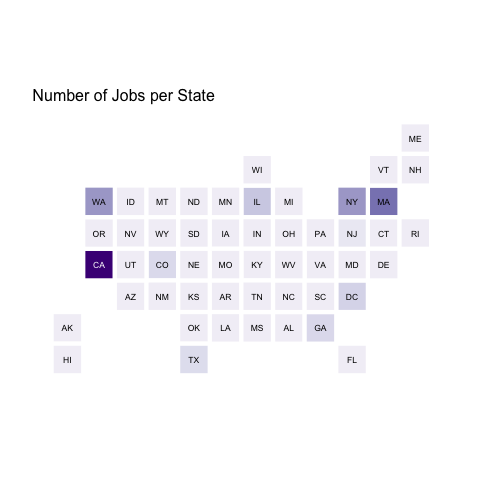

In [285]:
%%R

statebins(state, value_col = "company") +
labs(title = 'Number of Jobs per State') +
scale_fill_distiller(palette = "Purples") +
theme_statebins(legend_position = "none")

## The bottom label graph was a test

In [301]:
#reading in the data
data = pd.read_csv('/Users/dillonquan/Desktop/DataVizProject/ds_jobs/alldata.csv')
software = pd.read_csv('Data Scientist Job Search Terms - software skills.csv')
general = pd.read_csv('Data Scientist Job Search Terms - general skills.csv')

In [312]:
general2 = pd.concat([general.loc[[0,1,2,3,4,5,6,8,10,11,12,13,14,20,25], 'Keyword'], pd.Series(['nlp', ' ai '])], ignore_index=True)

0                machine learning
1                        analysis
2                      statistics
3                computer science
4                   communication
5                     mathematics
6                   visualization
7                   deep learning
8            software development
9                 neural networks
10               data engineering
11             project management
12           software engineering
13        artificial intelligence
14    natural language processing
15                            nlp
16                            ai 
dtype: object

In [305]:
from collections import Counter, defaultdict
software_count = {}
general_count = {}
for skill in software:
    software_count[skill.lower()] = 0
for skill in general2:
    general_count[skill.lower()] = 0
    
desc = data.description.dropna()

#Update software_count dict
for i in desc:
    set_of_words = set(i.lower().split())
    for word in set_of_words:
        if word.strip() in software_count:
            software_count[word] += 1

for j in desc:
    for i in general_count:
        indx = j.lower().find(i)
        if indx != -1:
            general_count[i] += 1

In [307]:
general_count

{' ai ': 420,
 'analysis': 3958,
 'artificial intelligence': 485,
 'communication': 4100,
 'computer science': 2403,
 'data engineering': 265,
 'deep learning': 592,
 'machine learning': 2452,
 'mathematics': 1184,
 'natural language processing': 447,
 'neural networks': 291,
 'nlp': 329,
 'project management': 626,
 'software development': 808,
 'software engineering': 464,
 'statistics': 2110,
 'visualization': 1016}

In [318]:
software = pd.DataFrame.from_dict(software_count, orient='index').reset_index()
general = pd.DataFrame.from_dict(general_count, orient='index').reset_index()
software.columns = ['skill', 'ct']
general.columns = ['skill', 'ct']
software.sort_values('ct', inplace=True)
general.sort_values('ct', inplace=True)
software.skill = pd.Categorical(software.skill, categories=software.skill, ordered=True)
general.skill = pd.Categorical(general.skill, categories=general.skill, ordered=True)

In [337]:
general.loc[(general.skill == 'nlp'), 'ct'] = 776
general.loc[(general.skill == ' ai '), 'ct'] = 905
general = general.drop([14, 13])

In [360]:
%R -i general

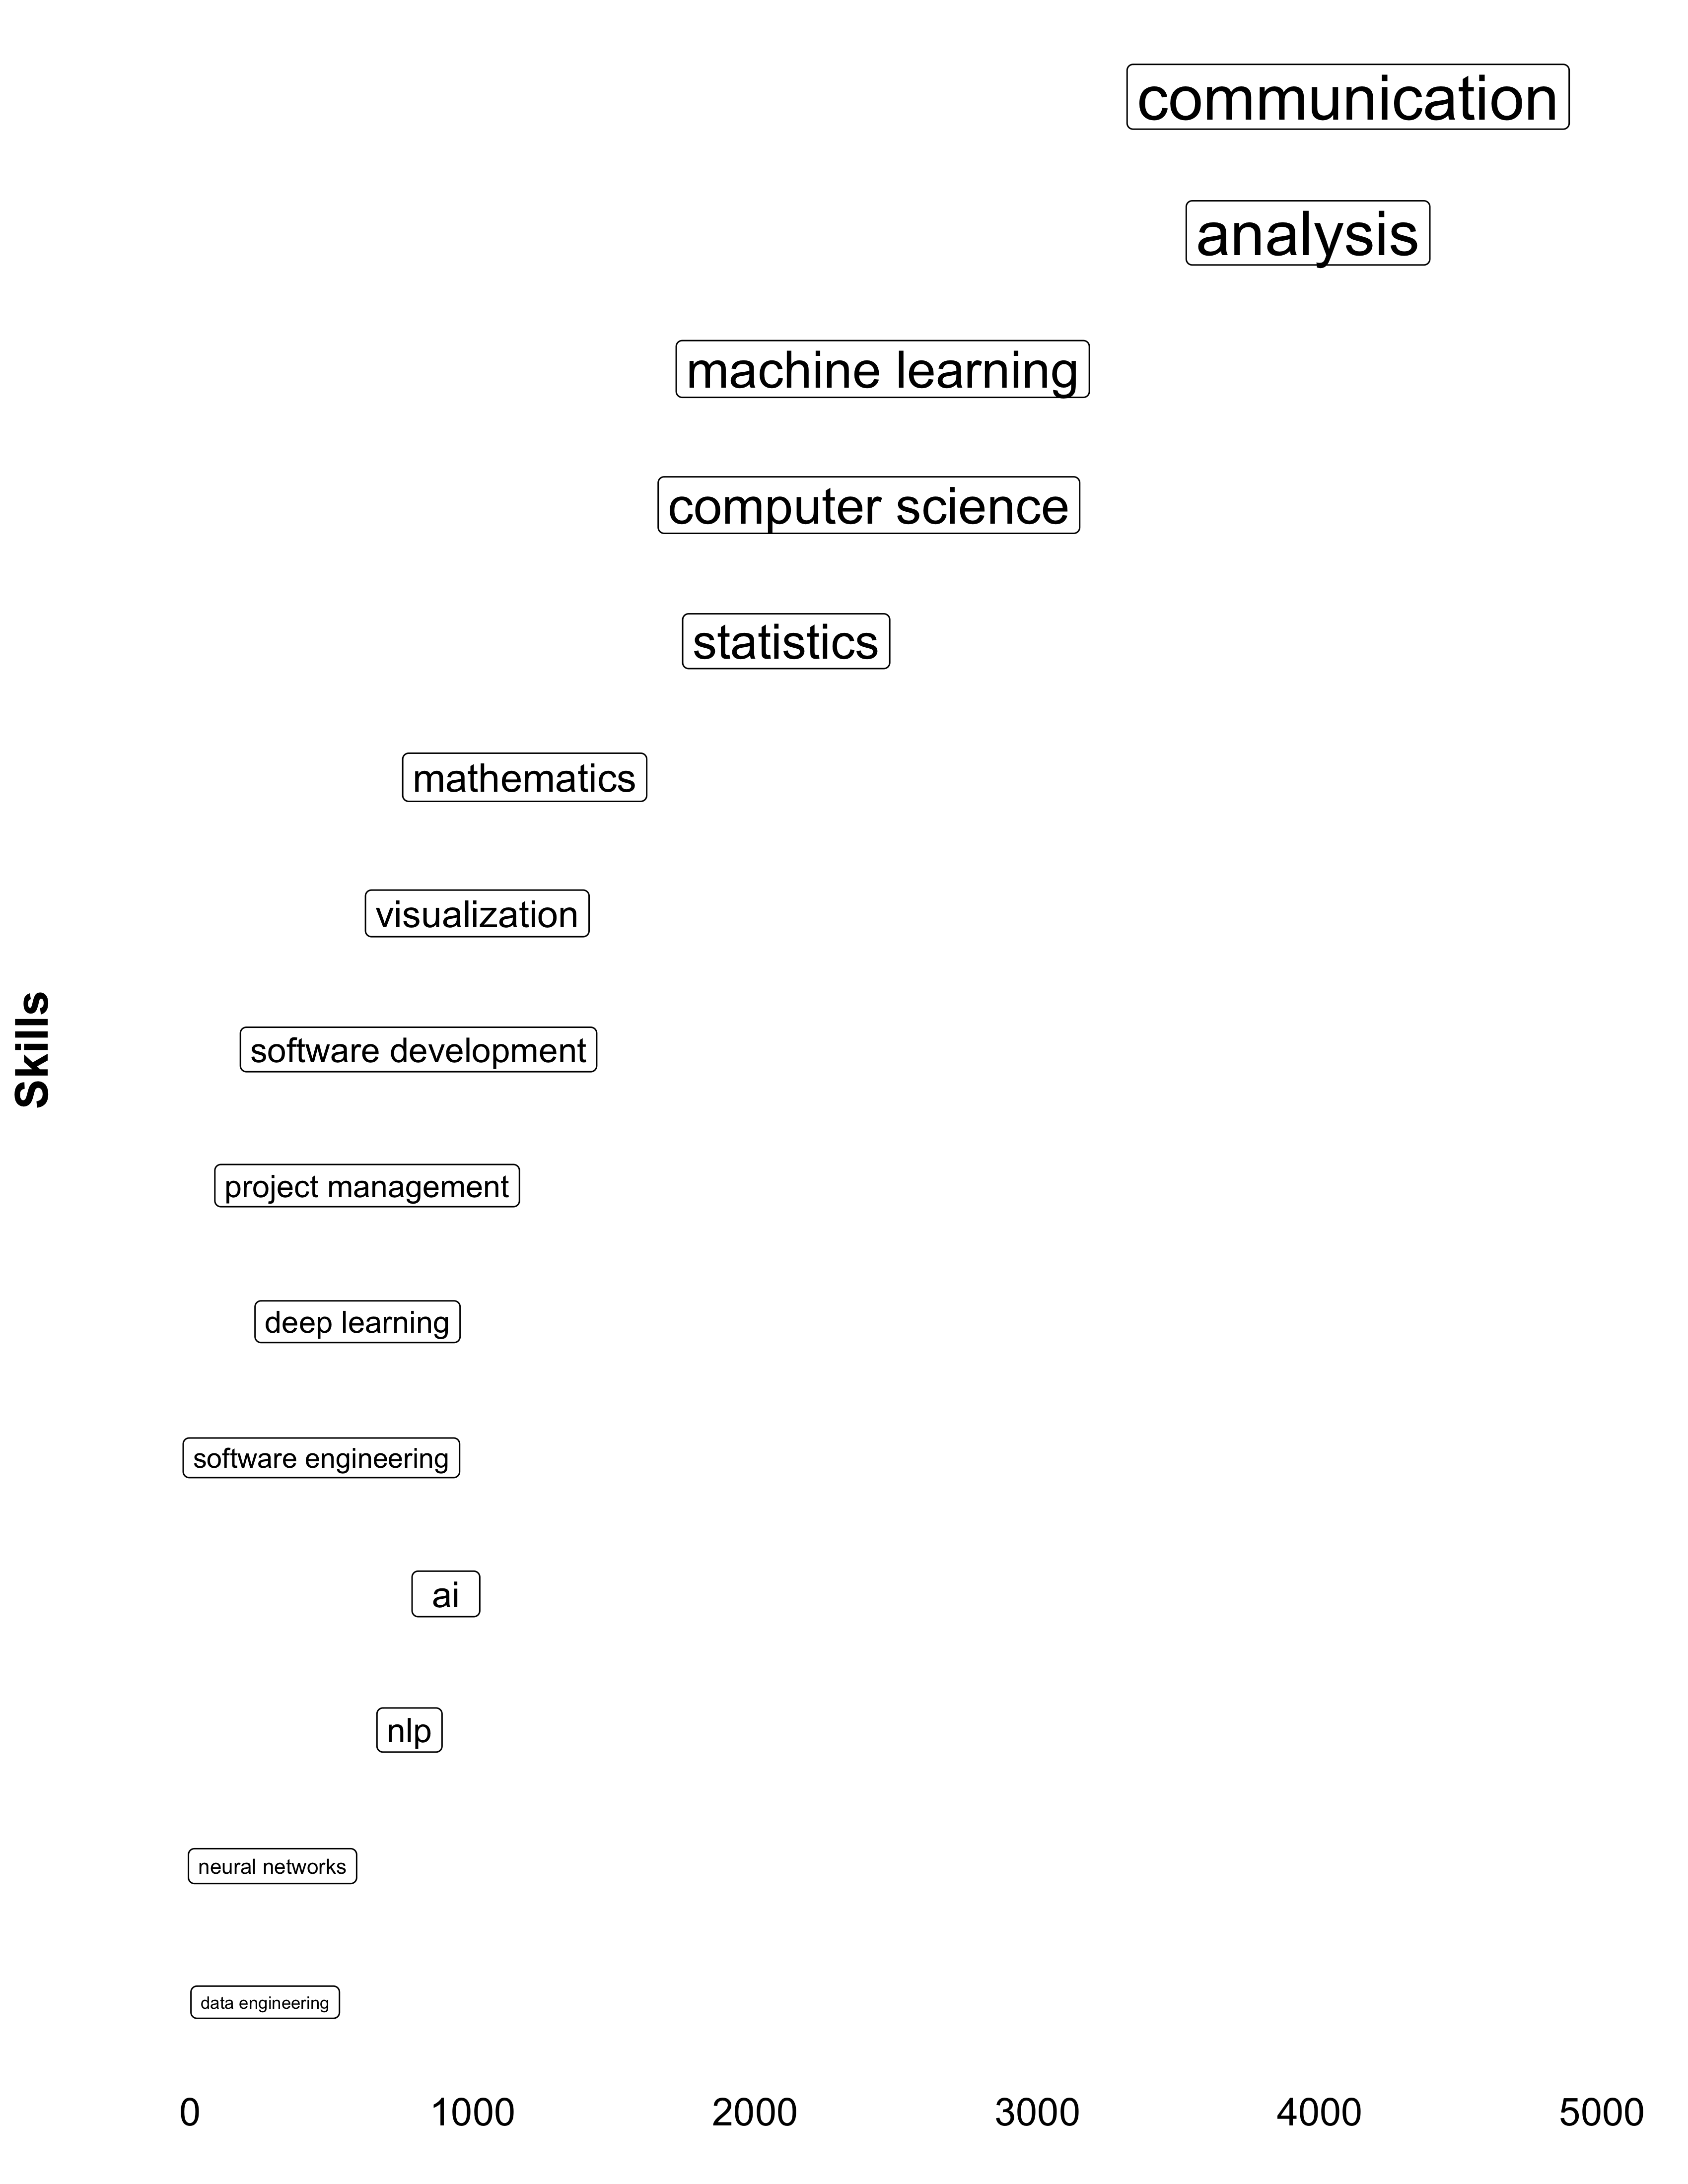

In [372]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + geom_label(aes(x = Skills, y = ct, label = Skills, size = ct), data = general) +
scale_y_continuous(limits = c(0, 5000), breaks = seq(0, 5000, by = 1000)) + 
scale_size(range = c(2.2, 8)) +
xlab('Skills') +
ylab('') +
theme(panel.grid.minor = element_blank(), panel.grid.major = element_blank(), panel.background = element_blank(),
      axis.ticks = element_blank(), legend.position = "none", axis.title.y = element_text(size = rel(1.5), face = 'bold', margin = margin(t = 0, r = 20, b = 0, l = 0)),
      axis.text.x = element_text(size= 14, colour = 'black'), axis.text.y = element_blank()) +
coord_flip()

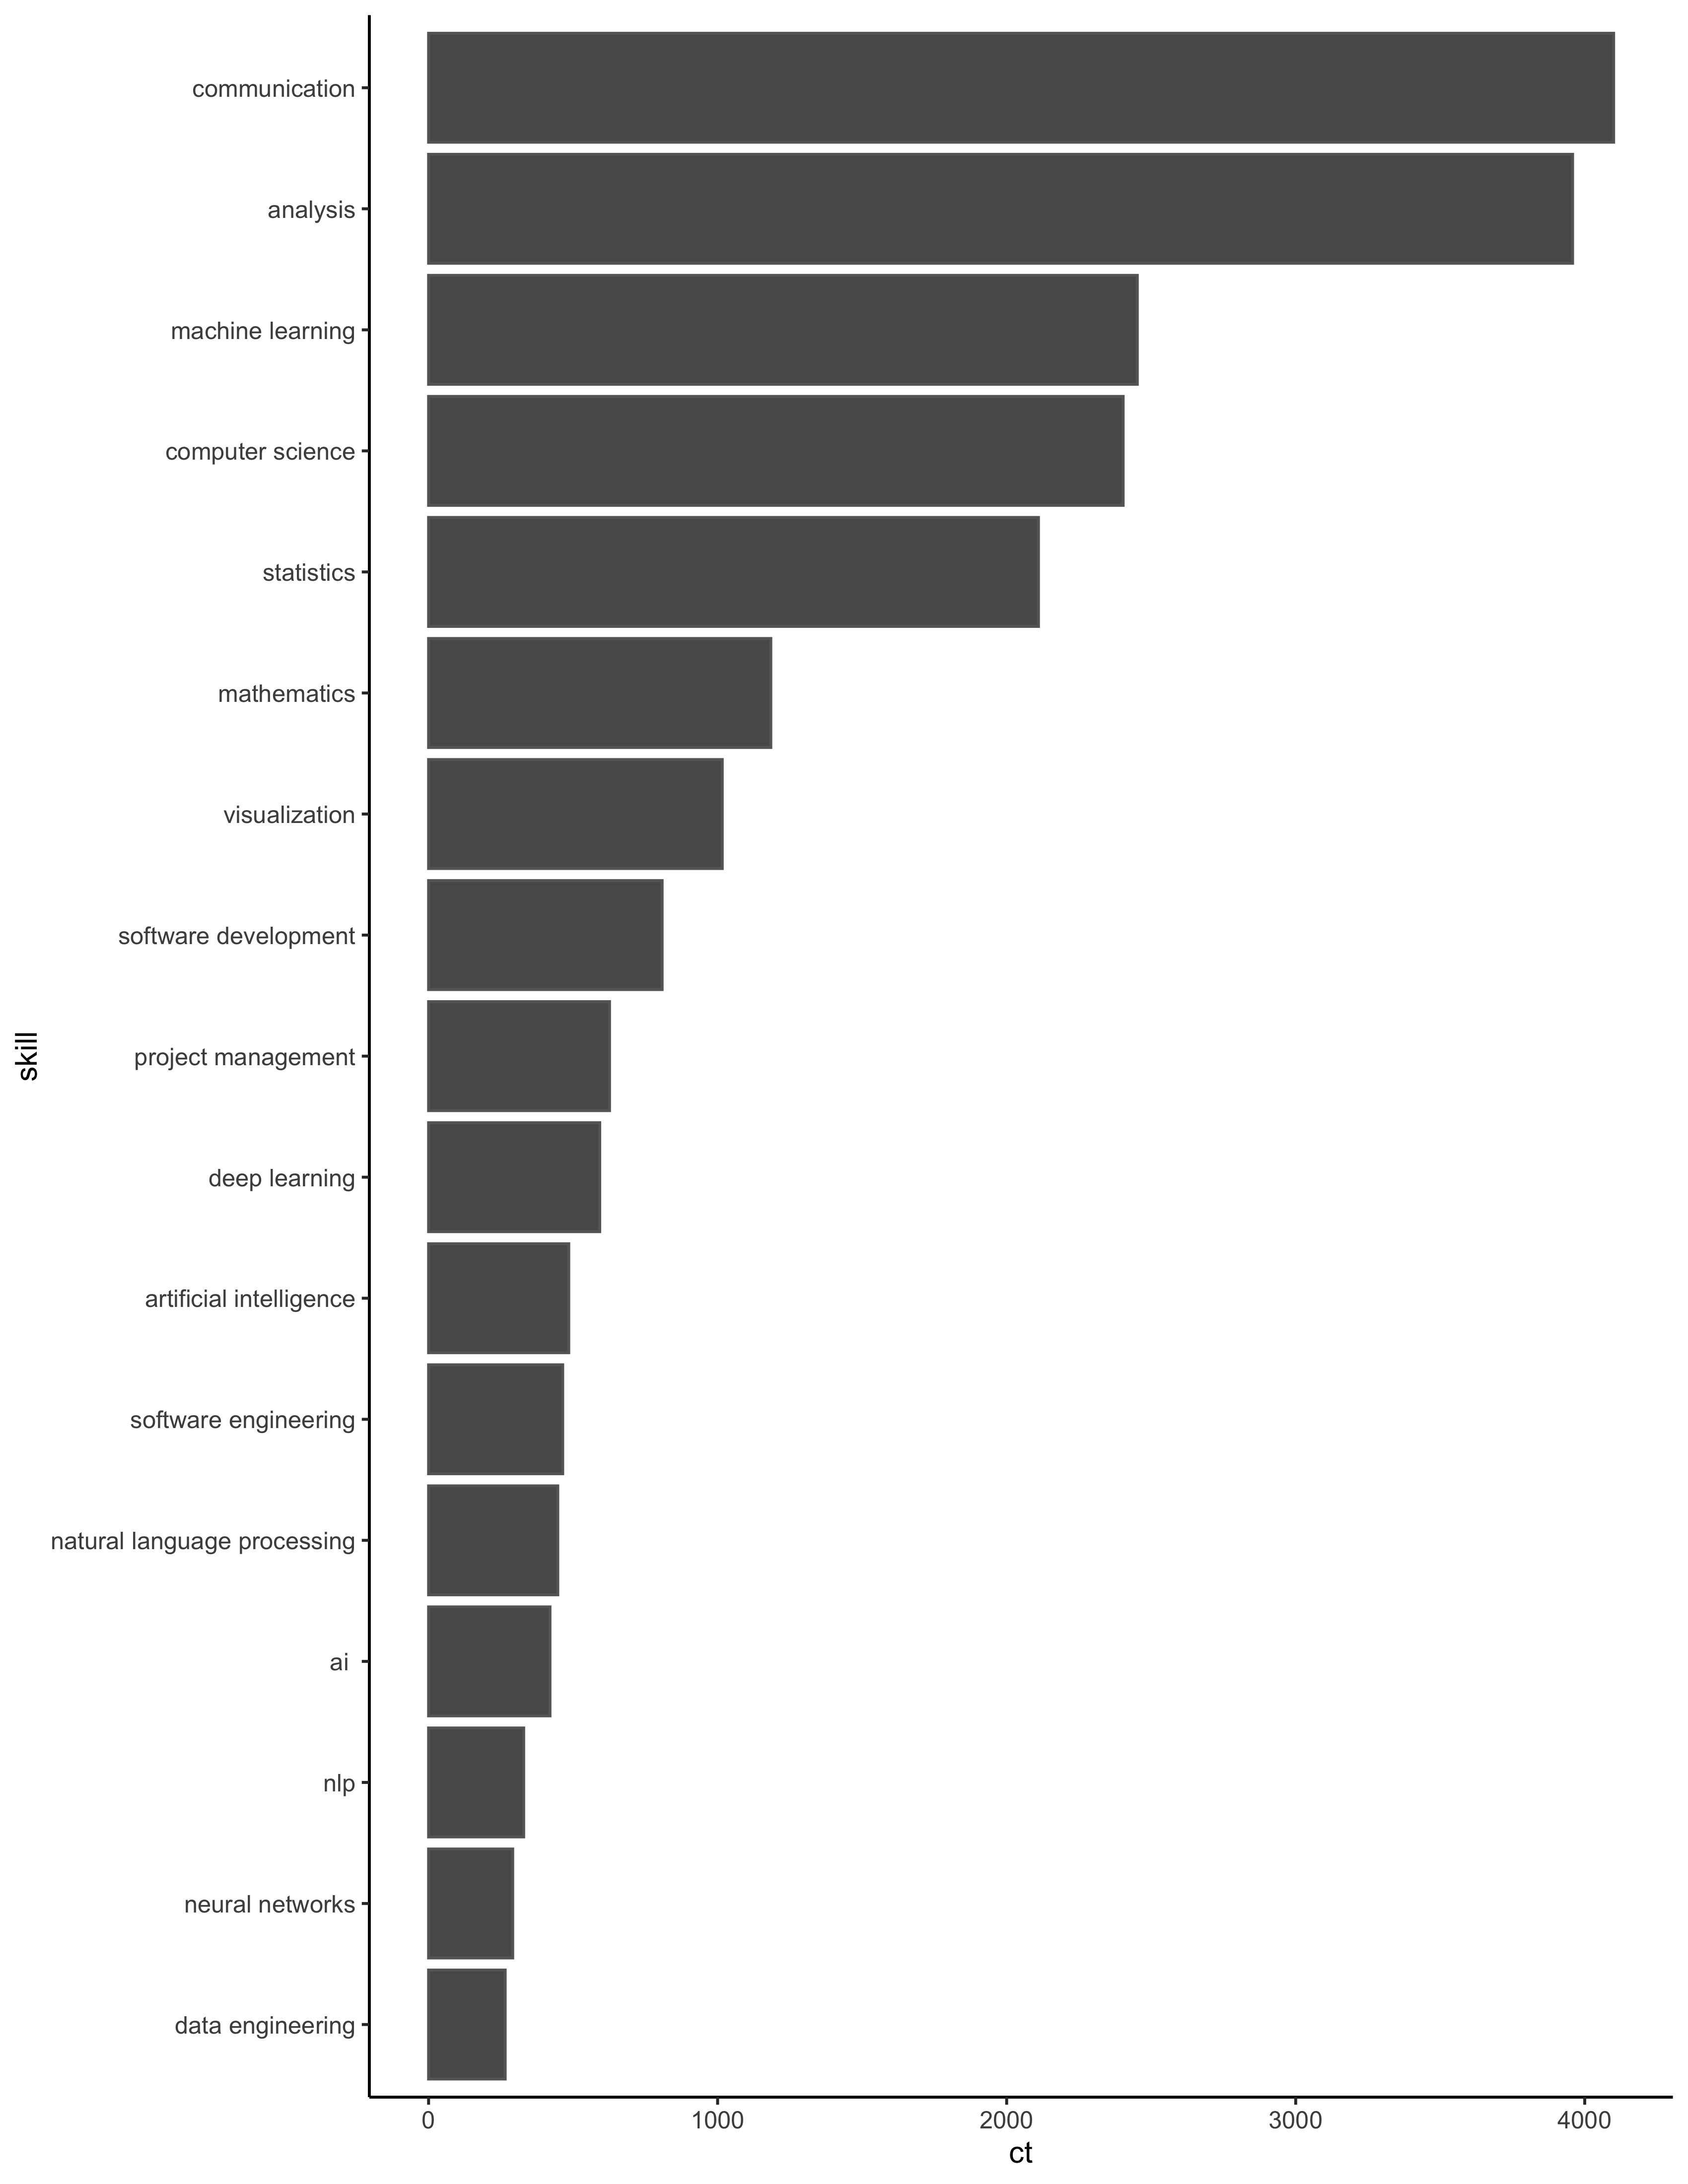

In [316]:
%%R -w 8.5 -h 11 --units in -r 400
ggplot() +
geom_col(aes(y=ct, x=skill), data=general, color='grey40') +
theme_bw() + theme_minimal() + theme_classic() + coord_flip()